In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Inspect residuals without Boxcox Transformation

In [98]:
data = pd.read_csv('AirPassengers.csv')
data['Month'] = pd.to_datetime(data['Month'])

# Split train and test
train = data.iloc[:-int(len(data) * 0.2)]
test = data.iloc[-int(len(data) * 0.2):]

In [99]:
# Import packages
from statsmodels.tsa.arima.model import ARIMA

# Split train and test
train = data.iloc[:-int(len(data) * 0.2)]
test = data.iloc[-int(len(data) * 0.2):]

# Train model
model = ARIMA(train['#Passengers'], order=(0, 0, 13)).fit()

/Users/dominikhonegger/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/Users/dominikhonegger/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [100]:
forecasts = model.forecast(len(test))

In [101]:
forecasts

116    469.316330
117    436.669137
118    400.481549
119    383.066013
120    363.492581
121    314.730922
122    298.503157
123    258.467028
124    233.536599
125    246.039529
126    246.682968
127    241.689165
128    240.559541
129    242.287657
130    242.287657
131    242.287657
132    242.287657
133    242.287657
134    242.287657
135    242.287657
136    242.287657
137    242.287657
138    242.287657
139    242.287657
140    242.287657
141    242.287657
142    242.287657
143    242.287657
Name: predicted_mean, dtype: float64

In [102]:
import plotly.graph_objects as go

def plot_func(forecast: list[float],
              title: str,
              ) -> None:
    """Function to plot the forecasts."""
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=train['Month'], y=train['#Passengers'], name='Train'))
    fig.add_trace(go.Scatter(x=test['Month'], y=test['#Passengers'], name='Test'))
    fig.add_trace(go.Scatter(x=test['Month'], y=forecast, name='Forecast'))
    fig.update_layout(template="simple_white", font=dict(size=18), title_text=title,
                      width=700, title_x=0.5, height=400, xaxis_title='Date',
                      yaxis_title='Passenger Volume')

    return fig.show()

plot_func(forecasts,  "ARIMA")


/Users/dominikhonegger/opt/anaconda3/lib/python3.9/site-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



In [103]:
train['fitted'] = model.fittedvalues
train['residuals'] = model.resid
train

/var/folders/l0/nq5ggf593ms2yg8yn6z63h_r0000gn/T/ipykernel_9364/3192927867.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l0/nq5ggf593ms2yg8yn6z63h_r0000gn/T/ipykernel_9364/3192927867.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Month,#Passengers,fitted,residuals
0,1949-01-01,112,242.287657,-130.287657
1,1949-02-01,118,116.496300,1.503700
2,1949-03-01,132,127.572338,4.427662
3,1949-04-01,129,144.721928,-15.721928
4,1949-05-01,121,133.663212,-12.663212
...,...,...,...,...
111,1958-04-01,348,361.174976,-13.174976
112,1958-05-01,363,364.647735,-1.647735
113,1958-06-01,435,430.341498,4.658502
114,1958-07-01,491,488.901871,2.098129


### Let's check whether the residuals show signs of autocorrelation

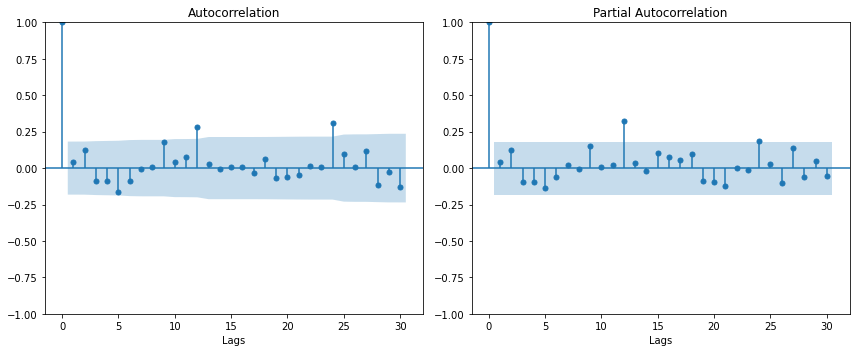

In [104]:
# Import packages
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
import matplotlib.pyplot as plt

# Plot ACF and PACF
fig, ax = plt.subplots(1,2,figsize=(12,5))
plot_acf(train['residuals'], lags=30, ax=ax[0])
ax[0].set_xlabel('Lags')
plot_pacf(train['residuals'], lags=30, ax=ax[1])
ax[1].set_xlabel('Lags')
plt.tight_layout()
plt.show()

In [105]:
train['residuals'].mean()

-0.7820037557732986

#### Most correlations are non-statistically significant (blue area), which would signify that the residuals are not correlated. However, there is a recurring pattern in the correlations.
1. This indicates that there is some seasonal component that the model may have not fully accounted for.
2. The mean is not zero, this means the predictions are biased.

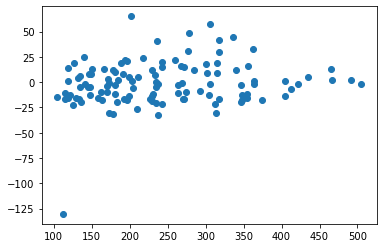

In [106]:
plt.scatter(train['#Passengers'],train['residuals'])

(array([ 5., 29., 19., 24., 19., 10.,  3.,  3.,  1.,  2.]),
 array([-32.24895428, -22.50575036, -12.76254645,  -3.01934253,
          6.72386139,  16.46706531,  26.21026923,  35.95347314,
         45.69667706,  55.43988098,  65.1830849 ]),
 <BarContainer object of 10 artists>)

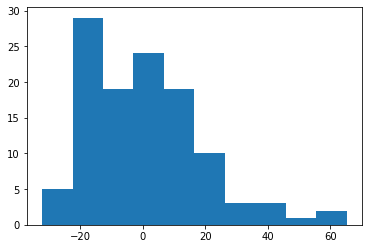

In [107]:
plt.hist(train['residuals'][1:])

## Inspect residual with Boxcox transformation

In [108]:
# Read in the data
data_arima = pd.read_csv('AirPassengers.csv')
data_arima['Month'] = pd.to_datetime(data_arima['Month'])

#data_arima.plot(x='Month',y='#Passengers')

In [109]:
# Import packages 
from scipy.stats import boxcox

# Make the target variance stationary
data_arima['Passengers_Boxcox'], lam = boxcox(data_arima['#Passengers'])

#data_arima.plot(x='Month',y='Passengers_Boxcox')

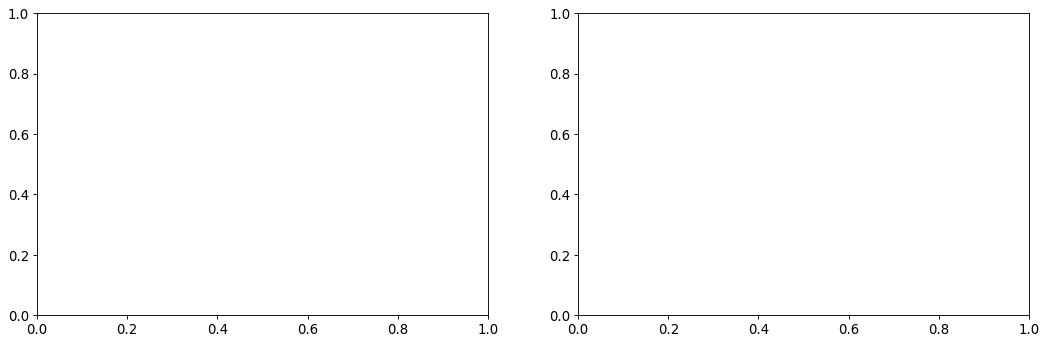

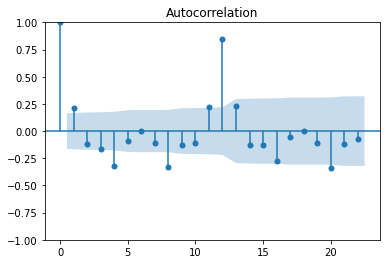

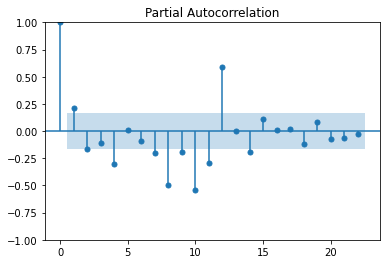

In [110]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

# Difference the data
data_arima["Passenger_diff"] = data_arima["Passengers_Boxcox"].diff()
data_arima.dropna(inplace=True)

# Plot acf and pacf
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5), dpi=80)
plot_acf(data_arima['Passenger_diff'])
plot_pacf(data_arima['Passenger_diff'], method='ywm')
ax1.tick_params(axis='both', labelsize=12)
ax2.tick_params(axis='both', labelsize=12)
#plt.show()

In [111]:
# Import packages
from statsmodels.tsa.arima.model import ARIMA
from scipy.special import inv_boxcox

# Split train and test
train = data_arima.iloc[:-int(len(data_arima) * 0.2)]
test = data_arima.iloc[-int(len(data_arima) * 0.2):]

# Build ARIMA model and inverse the boxcox
model = ARIMA(train['Passengers_Boxcox'], order=(15, 1, 20)).fit()
boxcox_forecasts = model.forecast(len(test))
forecasts = inv_boxcox(boxcox_forecasts, lam)

/Users/dominikhonegger/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/Users/dominikhonegger/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/Users/dominikhonegger/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/Users/dominikhonegger/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/Users/dominikhonegger/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting pa

In [112]:
# Import packages
import plotly.graph_objects as go

def plot_forecasts(forecasts: list[float], title: str) -> None:
    """Function to plot the forecasts."""
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=train['Month'], y=train['#Passengers'], name='Train'))
    fig.add_trace(go.Scatter(x=test['Month'], y=test['#Passengers'], name='Test'))
    fig.add_trace(go.Scatter(x=test['Month'], y=forecasts, name='Forecast'))
    fig.update_layout(template="simple_white", font=dict(size=18), title_text=title,
                      width=650, title_x=0.5, height=400, xaxis_title='Date',
                      yaxis_title='Passenger Volume')

    return fig.show()


# Plot the forecasts
plot_forecasts(forecasts, 'ARIMA')

/Users/dominikhonegger/opt/anaconda3/lib/python3.9/site-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



In [113]:
train['fitted'] = model.fittedvalues
train['residuals'] = model.resid
train

/var/folders/l0/nq5ggf593ms2yg8yn6z63h_r0000gn/T/ipykernel_9364/3192927867.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/l0/nq5ggf593ms2yg8yn6z63h_r0000gn/T/ipykernel_9364/3192927867.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Month,#Passengers,Passengers_Boxcox,Passenger_diff,fitted,residuals
1,1949-02-01,118,6.932822,0.105332,0.000000,6.932822
2,1949-03-01,132,7.161892,0.229069,6.932822,0.229069
3,1949-04-01,129,7.114611,-0.047281,7.219185,-0.104574
4,1949-05-01,121,6.983787,-0.130824,7.080027,-0.096240
5,1949-06-01,135,7.208265,0.224479,6.939187,0.269078
...,...,...,...,...,...,...
111,1958-04-01,348,9.309366,-0.094067,9.411623,-0.102257
112,1958-05-01,363,9.410032,0.100666,9.418358,-0.008326
113,1958-06-01,435,9.848861,0.438829,9.831773,0.017088
114,1958-07-01,491,10.149186,0.300325,10.124659,0.024527


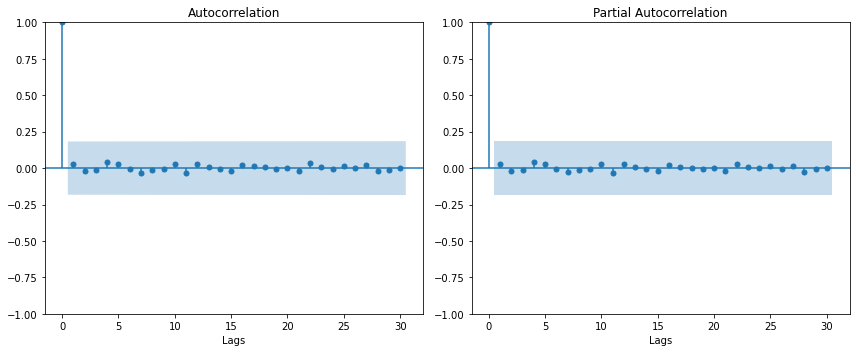

In [114]:
# Import packages
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
import matplotlib.pyplot as plt

# Plot ACF and PACF
fig, ax = plt.subplots(1,2,figsize=(12,5))
plot_acf(train['residuals'], lags=30, ax=ax[0])
ax[0].set_xlabel('Lags')
plot_pacf(train['residuals'], lags=30, ax=ax[1])
ax[1].set_xlabel('Lags')
plt.tight_layout()
plt.show()

In [115]:
train['residuals'].mean()

0.069342106833614

(array([ 3.,  6., 16., 20., 28., 20.,  6.,  7.,  4.,  4.]),
 array([-0.20486687, -0.15747237, -0.11007787, -0.06268337, -0.01528887,
         0.03210563,  0.07950013,  0.12689463,  0.17428913,  0.22168363,
         0.26907813]),
 <BarContainer object of 10 artists>)

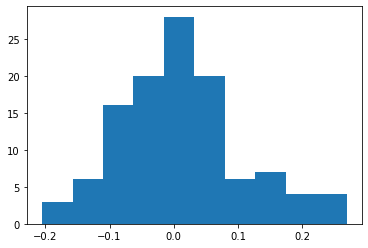

In [116]:
plt.hist(train['residuals'][1:])

### Great! All lags are insignificant, no signs of autocorrelation across the resiudals
1. Since the residuals are uncorrelated, there is no information left in the residuals which should be used in computing the forecasts.
2. The mean of the resiudals is close to 0. This indicates that there is some bias in the prediction.
3. It is also useful if: residuals are normally distirbuted and have aconstant variance (homoscedasticity).

#### To fix the bias, we could add the mean m to the forecasts.

#### A more quantitative way to determine if the residuals are correlated is to carry out the Ljung-Box statistical test:

H0: No autocorrelation

H1: Autocorrelation

In [117]:
# Import packages
from statsmodels.stats.diagnostic import acorr_ljungbox

# Carry out Ljung-Box test
print(acorr_ljungbox(train['residuals'], return_df=True))

     lb_stat  lb_pvalue
1   0.105540   0.745281
2   0.147642   0.928838
3   0.179894   0.980768
4   0.362904   0.985400
5   0.457229   0.993606
6   0.464660   0.998242
7   0.590500   0.999043
8   0.607227   0.999722
9   0.610297   0.999929
10  0.713005   0.999964


Since the p-values are very high, there is no reason to reject H0